# Subset our Graph to Representative Nodes and Edges
Utilizes a random walk

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

In [3]:
inout_dir = "../data/graphs/"

In [4]:
G = nx.read_gpickle(inout_dir +  "cosineGraph_K5.pkl")
G_avg = nx.read_gpickle(inout_dir +  "cosineGraph_K10_averaged.pkl")
G, G_avg

(<networkx.classes.multidigraph.MultiDiGraph at 0x1fc43a6d128>,
 <networkx.classes.graph.Graph at 0x1fc142c3b70>)

In [5]:
cluster_df = pd.read_csv(inout_dir +  "cosine_cluster5.csv")
cluster_df

subject_id  cluster
0              4        0
1            314        0
2            761        0
3           1152        0
4           3064        0
...          ...      ...
2879       95118        1
2880       90886        1
2881       92933        1
2882       96040        1
2883       99685        1

[2884 rows x 2 columns]

In [6]:
# write graph to CSVs for use in R 
def exportR(G, name, directory):
    v = pd.DataFrame(G.nodes(), columns = ["subject_id"])
    print(v.shape)
    e = nx.to_pandas_edgelist(G)
    try:
        e.drop(columns = "rank", inplace = True)
    except:
        pass
    
    # save
    v.to_csv(directory + f"sampledGraphs/{name} vertices sampled.csv", index = False)
    e.to_csv(directory + f"sampledGraphs/{name} edges sampled.csv", index = False)

In [7]:
# Random walk sampling of a graph 
def randomWalkSample(G_sub, num_nodes, num_edges = None, num_iters = 10, steps = 1000, seeds = None):
    visited_nodes = {}
    traversed_edges = {}
    num_edges = num_nodes if num_edges is None else num_edges 
    
    counter = 0
    
    for i in range(num_iters):

        # select our random starting node
        np.random.seed(seeds[i]) if seeds is not None else np.nan
        node_id = np.random.choice(G_sub.nodes)
        
        
        for j in range(steps):
            e = [node_id,0,0]
            # add to our count of visited nodes 
            try:
                visited_nodes[node_id] += 1
            except KeyError:
                visited_nodes[node_id] = 1
                
            # identify potential steps and select randomly
            neighbors = list(G_sub.neighbors(node_id))
            try:
                node_id = np.random.choice(neighbors)
            except:
                counter += 1
                #raise ValueError
                node_id = random.choice(list(G_sub.nodes))
                # this means this node had no edges in the cluster so we restart the random walk
                continue
            
            # add edges
            e[1] = node_id
            e = tuple(e)
            try: 
                traversed_edges[e] += 1
            except KeyError:
                traversed_edges[e] = 1
                
            
    # identify our most visited nodes
    most_visited_nodes = sorted(visited_nodes, key = visited_nodes.get,reverse = True)
    top_nodes = most_visited_nodes[:num_nodes]
    
    # identify our most visited edges
    most_visited_edges = sorted(traversed_edges, key = traversed_edges.get, reverse = True)
    top_edges = most_visited_edges[:num_edges]
    
    
    print("Number of nodes met with no edges: " + str(counter))
    
    return top_nodes, top_edges

Number of nodes met with no edges: 0


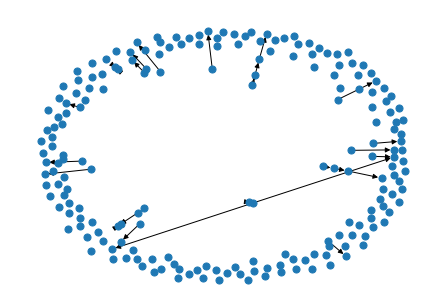

In [8]:
# run random sampling
np.random.seed(0)
seeds = np.random.randint(10, size =10)

top_nodes, top_edges = randomWalkSample(G_avg, 200, 200 * 15)
H = G.subgraph(top_nodes)
H = H.edge_subgraph(top_edges)

nx.draw(H, node_size = 50)
plt.show()

In [9]:
len(G[4])

92

In [10]:
# function that does this by cluster and automatically determines the sampling amount
# we just pick the representative nodes by cluster, but we get the edges from the whole graph
def subgraphCluster(G_tmp, cluster_df, sample_percent = .1, edge_sample_percent = 1,
                    num_iters = 10, steps = 1000, seed = 0):
    num_clusters = max(cluster_df.cluster)+1
    
    # init variables
    nodes2keep = []
    edges2keep = []
    np.random.seed(seed)
    seeds = np.random.randint(10, size =10)

    # add our cluster information to the graph
    nx.set_node_attributes(G_tmp, dict(zip(cluster_df.subject_id, cluster_df.cluster)), 'cluster')
    
    for c in range(num_clusters):
        # subset graph to just those in our cluster
        c_nodes = list(cluster_df.loc[cluster_df.cluster == c, "subject_id"])
        G_cluster_tmp = G_tmp.subgraph(c_nodes)
        
        # sample our cluster graph 
        sampled_nodes = int(len(c_nodes)*sample_percent)
        top_nodes, _ = randomWalkSample(G_cluster_tmp, sampled_nodes, sampled_nodes *20)
        nodes2keep += top_nodes
       
    # sample
    H = G_tmp.subgraph(nodes2keep)
    # if we want to subset edges then we need to perform a second random walk on the sampled graph
    # this way we can ensure we get edges between nodes in different clusters
    if edge_sample_percent < 1:
        _, top_edges = randomWalkSample(H, int(len(H.nodes)/2), int(len(H.nodes)*(92*edge_sample_percent)))
        edges2keep += top_edges
        sampled_edges = H.edge_subgraph(edges2keep)
        
        # I need to have the full edges graph too for sampling the data subgroups
        return H, sampled_edges
    
    return H, H.edges


Number of nodes met with no edges: 0
Number of nodes met with no edges: 0
Number of nodes met with no edges: 0
Number of nodes met with no edges: 0
Number of nodes met with no edges: 0
(720, 1)


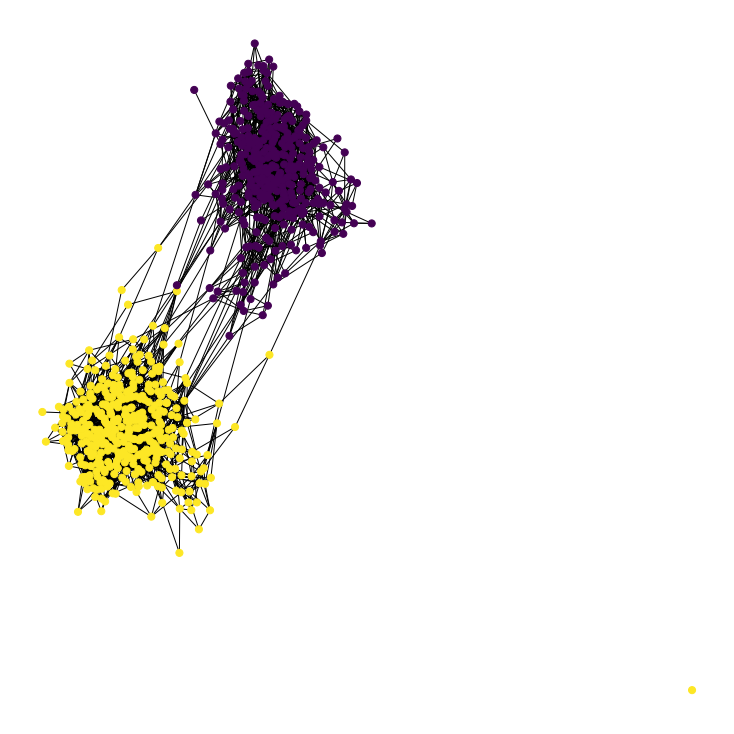

In [11]:
G_nodes, _ = subgraphCluster(G, cluster_df, .2, edge_sample_percent = .33, seed =1)
G_cluster, _ = subgraphCluster(G_avg, cluster_df, .25, seed =1)


nx.write_gpickle(nx.DiGraph(G_cluster), inout_dir + "sampledGraphs/all sample.pkl")
exportR(nx.DiGraph(G_cluster), "all", inout_dir)
plt.figure(figsize=(10,10))
nx.draw(G_cluster, node_size = 50, node_color = list(nx.get_node_attributes(G_cluster,'cluster').values()))
plt.show()

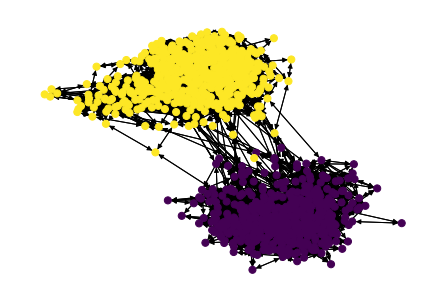

In [41]:
# make sure save method actualy worked
test_graph = nx.read_gpickle(inout_dir + "sampledGraphs/all sample.pkl")
nx.draw(test_graph, node_size = 50, node_color = list(nx.get_node_attributes(test_graph,'cluster').values()))


hepatitis


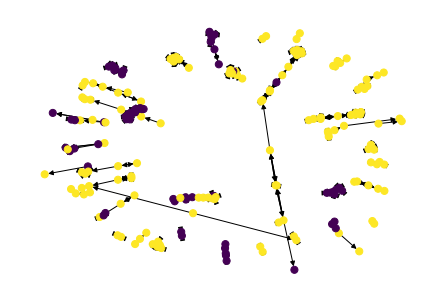

blood


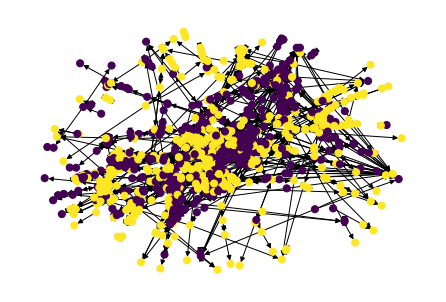

demographics


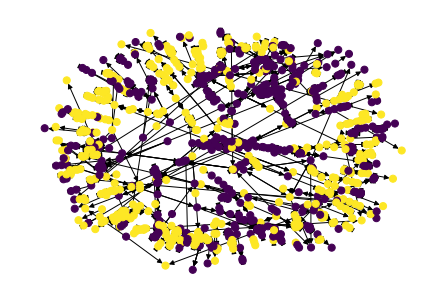

mental drug


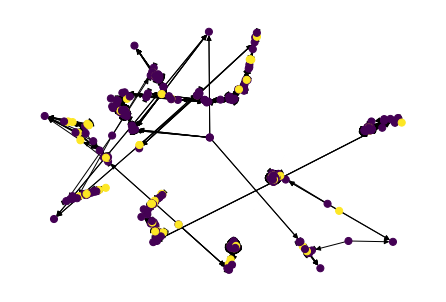

antibodies


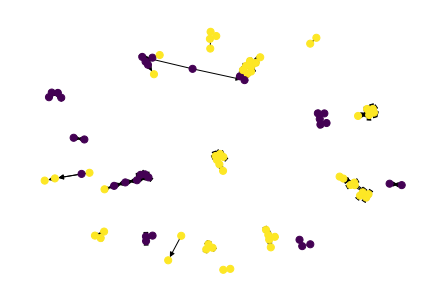

heart lung


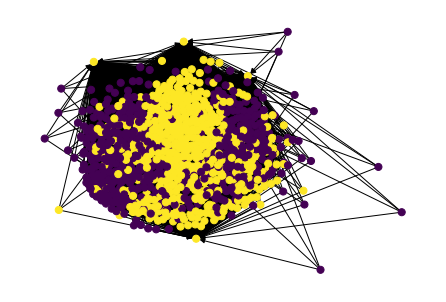

other lab


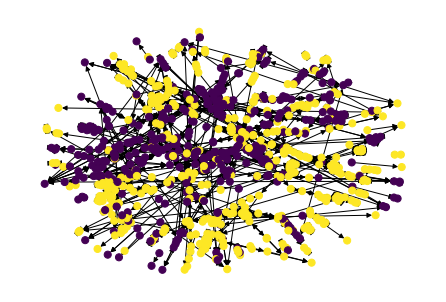

breakdown products


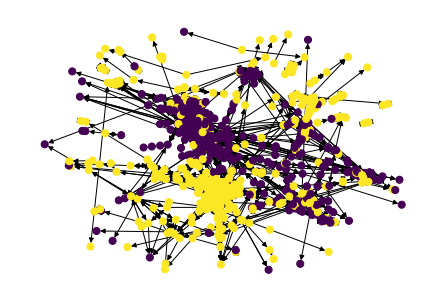

proteins


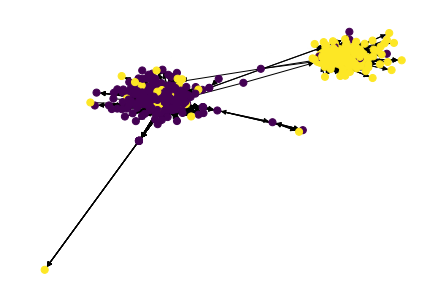

pain


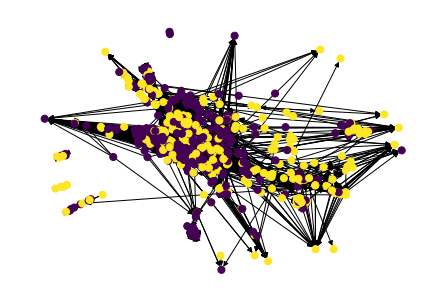

diet


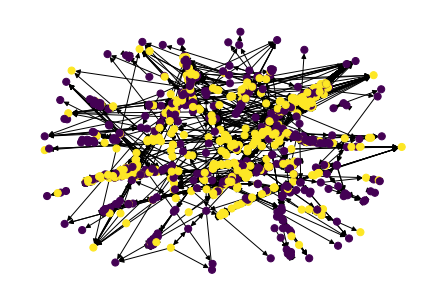

physical assessment


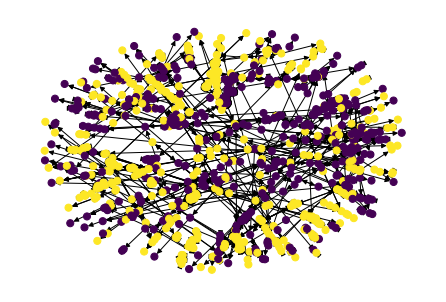

enzymes


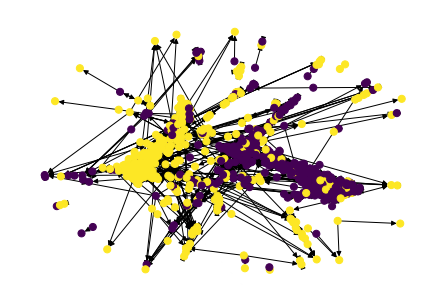

activity


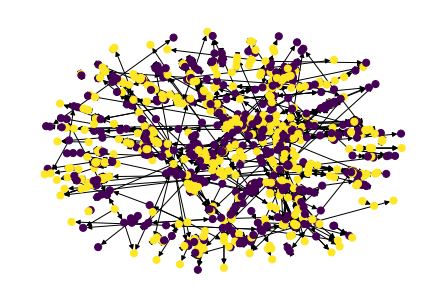

In [292]:
# sample our data subgroups
e_by_group = nx.get_edge_attributes(G_nodes,'data_group')
subgroups = set(e_by_group.values())

for group in subgroups:
    print(group)
    es = [k for (k,v) in e_by_group.items() if v == group]
    G_subgroup = G_nodes.edge_subgraph(es)
    
    # save and draw
    nx.write_gpickle(nx.DiGraph(G_subgroup), inout_dir + "sampledGraphs/" + group + " sample.pkl")
    nx.draw(G_subgroup, node_size = 50, node_color = list(nx.get_node_attributes(G_subgroup,'cluster').values()))
    plt.show()

activity
Number of nodes met with no edges: 5
Number of nodes met with no edges: 0
(498, 1)


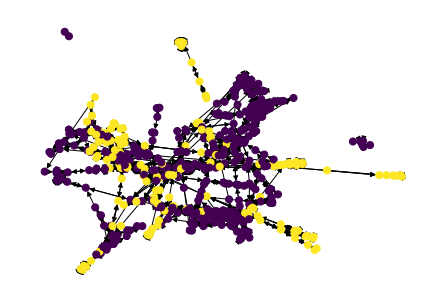

antibodies
Number of nodes met with no edges: 0
Number of nodes met with no edges: 1
(175, 1)


physical assessment
Number of nodes met with no edges: 2
Number of nodes met with no edges: 2
(548, 1)


heart lung
Number of nodes met with no edges: 0
Number of nodes met with no edges: 10000
(406, 1)


proteins
Number of nodes met with no edges: 0
Number of nodes met with no edges: 0
(720, 1)


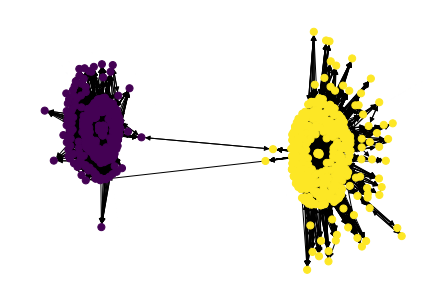

hepatitis
Number of nodes met with no edges: 0
Number of nodes met with no edges: 2
(252, 1)


other lab
Number of nodes met with no edges: 0
Number of nodes met with no edges: 2
(720, 1)


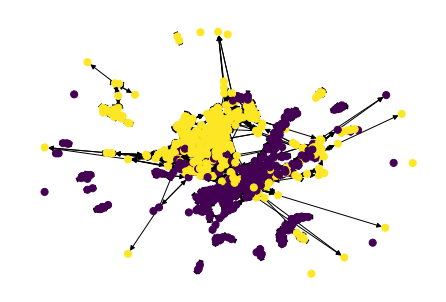

pain
Number of nodes met with no edges: 0
Number of nodes met with no edges: 9
(445, 1)


diet
Number of nodes met with no edges: 4
Number of nodes met with no edges: 6
(536, 1)


blood
Number of nodes met with no edges: 1
Number of nodes met with no edges: 0
(720, 1)


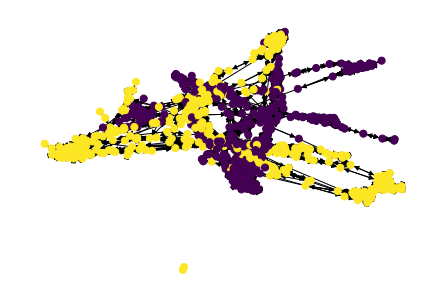

breakdown products
Number of nodes met with no edges: 0
Number of nodes met with no edges: 6
(720, 1)


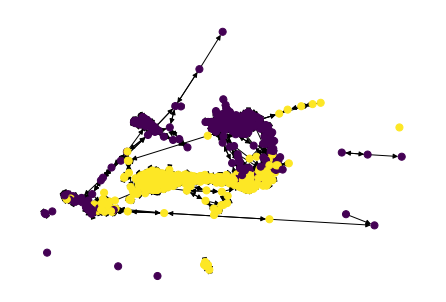

medical history
Number of nodes met with no edges: 15
Number of nodes met with no edges: 0
(417, 1)


demographics
Number of nodes met with no edges: 0
Number of nodes met with no edges: 0
(720, 1)


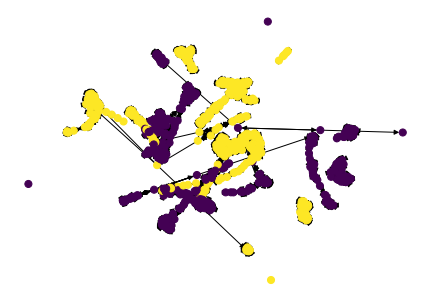

enzymes
Number of nodes met with no edges: 0
Number of nodes met with no edges: 0
(715, 1)


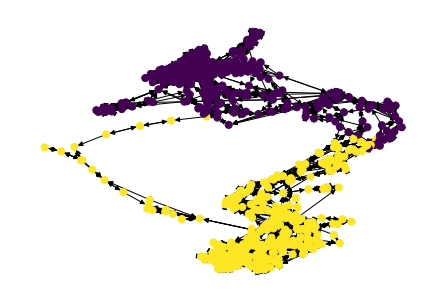

In [43]:
# what happens if I random walk each group instead?
e_by_group = nx.get_edge_attributes(G,'data_group')
subgroups = set(e_by_group.values())

for group in subgroups:
    print(group)
    es = [(k[0], k[1]) for (k,v) in e_by_group.items() if v == group]
    
    # subset nodes and edges 
    G_subgroup = nx.DiGraph()
    nodes = list(set([item for sublist in es for item in sublist]))
    G_subgroup.add_nodes_from(nodes)
    G_subgroup.add_edges_from(es)
        
    G_subgroup_sampled, _ = subgraphCluster(G_subgroup, cluster_df, sample_percent = .25, seed =1)

    
    # save and draw
    nx.write_gpickle(nx.DiGraph(G_subgroup_sampled), inout_dir + "sampledGraphs/" + group + " sample.pkl")
    exportR(nx.DiGraph(G_subgroup_sampled), group, inout_dir)
    nx.draw(G_subgroup_sampled, node_size = 50, 
            node_color = list(nx.get_node_attributes(G_subgroup_sampled,'cluster').values()))
    plt.show()